# Aplicando Transfer Learning com Data Augmentation

O objetivo é diferenciar imagens de alimentos de imagens que não são de alimentos.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os, shutil


# Permite à GPU alocar mais memória para o tensorflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

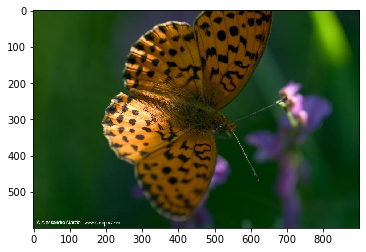

In [2]:
# Visualizando uma imagem do dataset
plt.imshow(image.load_img('Food-5K/training/0_454.jpg'))
plt.show()

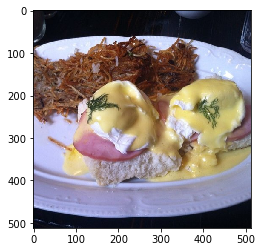

In [3]:
# Imagens de comida começam com "1" no nome do arquivo, as que não são de comida começam com "0"
plt.imshow(image.load_img('Food-5K/training/1_230.jpg'))
plt.show()

In [4]:
# # Criando as pastas no formato que o Keras image-generator aceita
# # As imagens foram movidas para lá manualmente.
# os.makedirs('data/train')
# os.makedirs('data/test')
# os.makedirs('data/train/nonfood')
# os.makedirs('data/train/food')
# os.makedirs('data/test/nonfood')
# os.makedirs('data/test/food')

In [5]:
# Parâmetros para o ImageGenerator
train_path = "data/train"
test_path = "data/test"

IMAGE_SIZE = [128, 128] # Tamanho das imagens desejado

In [6]:
# Lista dos caminhos das imagens de treinamento e teste
image_files = glob(train_path + "/*/*.jpg")
test_image_files = glob(test_path + "/*/*.jpg")

In [7]:
# Lista usada para obter o número de classes
folders = glob(train_path + "/*")

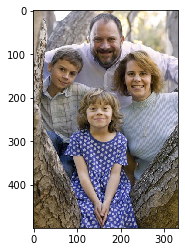

In [8]:
# Dando uma olhada em uma imagem dos dados de treinamento
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [9]:
# Criando o objeto do modelo pré-treinado
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], # Dimensões R, G, B.
                      weights="imagenet", # Usa os pesos de uma VGG treinada no dataset "ImageNet".
                      include_top=False)  # Include_top = false só nos retorna as layers até a última convolution,
                                          # sem retornar as dense layers. Ou seja, só retorna o "corpo" da rede neural.
    
vgg16.trainable = False # Devemos setar os pesos da rede neural como "False", para não atualizarmos os parâmetros
                        # que já foram obtidos no treinamento sobre o dataset imagenet.

In [10]:
# Criando a "cabeça" da rede neural; A parte faltante do modelo.
K = len(folders) # Número de classes
x = Flatten()(vgg16.output)
x = Dense(K, activation='softmax')(x) # Softmax activation function geralmente é usada quando seus targets estão
                                      # no formato "one-hot encoded". # O ImageDataGenerator gera os dados nesse 
                                      # formato, então usaremos a Softmax.Sigmoid usamos quando estão no formato 
                                      # numérico.
                                      
# "Encaixando o corpo com a cabeça" (concatenando o modelo pré-treinado com as dense layers)
model = Model(inputs=vgg16.input, outputs=x)

In [11]:
# Visualizando o objeto do modelo
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [12]:
# Criando uma instância do ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input) # Preprocess_input vem do módulo VGG. Ele serve para que o image generator
                                             # gere imagens já no formato apropriado para a rede VGG.

In [13]:
# Criando os generators
batch_size = 128

train_generator = gen.flow_from_directory(
    train_path,
    shuffle=True,
    target_size=IMAGE_SIZE,
    batch_size=batch_size)

test_generator = gen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [14]:
# Compilando e treinando o modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

historico = model.fit(train_generator, validation_data=test_generator, epochs=10, 
              steps_per_epoch=int(np.ceil(len(image_files) / batch_size)), # Numero de train steps por epoch
              validation_steps=int(np.ceil(len(test_image_files) / batch_size))) # Numero de test steps por epoch

Train for 24 steps, validate for 8 steps
Epoch 1/10
24/24 [==============================] - 37s 2s/step - loss: 2.1875 - accuracy: 0.8947 - val_loss: 0.7345 - val_accuracy: 0.9600
Epoch 2/10
24/24 [==============================] - 27s 1s/step - loss: 0.6654 - accuracy: 0.9670 - val_loss: 0.6491 - val_accuracy: 0.9620
Epoch 3/10
24/24 [==============================] - 27s 1s/step - loss: 0.4750 - accuracy: 0.9747 - val_loss: 0.6605 - val_accuracy: 0.9600
Epoch 4/10
24/24 [==============================] - 26s 1s/step - loss: 0.2490 - accuracy: 0.9833 - val_loss: 0.8287 - val_accuracy: 0.9660
Epoch 5/10
24/24 [==============================] - 26s 1s/step - loss: 0.3170 - accuracy: 0.9810 - val_loss: 0.8484 - val_accuracy: 0.9590
Epoch 6/10
24/24 [==============================] - 26s 1s/step - loss: 0.2218 - accuracy: 0.9827 - val_loss: 0.8527 - val_accuracy: 0.9660
Epoch 7/10
24/24 [==============================] - 26s 1s/step - loss: 0.2100 - accuracy: 0.9843 - val_loss: 0.8886 - 

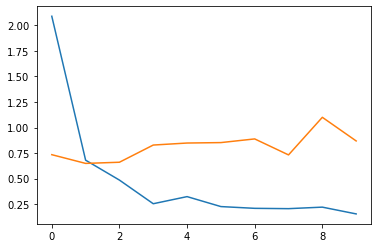

In [15]:
# Plotando a loss
plt.plot(historico.history['loss'], label='train_loss')
plt.plot(historico.history['val_loss'], label='test_loss')
plt.show()

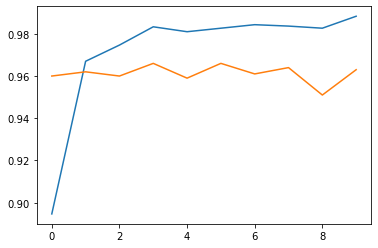

In [16]:
# Plotando a acurácia
plt.plot(historico.history['accuracy'], label='train_accuracy')
plt.plot(historico.history['val_accuracy'], label='test_accuracy')
plt.show()